# Control 3


### Nombre estudiante: Matías Duhalde

*Nota para ayudante: Acá se explica lo mismo, y se colocan los mismos fragmentos de código que en el README, por lo que no es necesario revisar este último muy detalladamente. El README se incluyó por formalidad y para cumplir con lo del enunciado.*

## 1. Manejo de Datos

Para importar los datos desde el archivo `Resultados_plebiscito.csv` a la base de datos en SQLite3, se usó la CLI directamente. Los comandos utilizados fueron los siguientes:
```SQL
.open municipios.db

CREATE TABLE Resultados_Plebiscito(
    cod_com INTEGER PRIMARY KEY,
    apruebo INTEGER,
    rechazo INTEGER,
    blancos INTEGER,
    nulos INTEGER,
    FOREIGN KEY(cod_com) REFERENCES Comuna(id)
);

.separator ,

.import Resultados_Pleb.csv Resultados_Plebiscito
```

De esta manera, se agregan los datos del csv a una relación llamada `Resultados_Plebiscito`, con el esquema anterior.

## 2.1 Correlación entre habitantes y presupuesto

#### Importar librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

#### Obtener información de base de datos

In [2]:
# Connect to database
conn = sqlite3.connect('municipios.db')
conn.text_factory = lambda x: str(x, "latin-1")

# Create cursor
c = conn.cursor()

# Obtain data
query = '''
SELECT presupuesto.id_comuna, presupuesto.municipio, presupuesto.plata, poblacion.habitantes FROM presupuesto
INNER JOIN poblacion
ON presupuesto.id_comuna = poblacion.cod
'''
result = c.execute(query)

hab_pres_frame = pd.DataFrame(result)

conn.close()

hab_pres_frame.columns = ["id_comuna", "nombre", "presupuesto", "habitantes"]
hab_pres_frame

,id_comuna,nombre,presupuesto,habitantes
0,1101,IQUIQUE,59072234,191468
1,1107,ALTO HOSPICIO,13984404,108375
2,1401,POZO ALMONTE,7613962,15711
3,1402,CAMIÑA,1584008,1250
4,1403,COLCHANE,2500000,1728
...,...,...,...,...
312,14204,RÍO BUENO,5771272,31372
313,15101,ARICA,37808221,221364
314,15102,CAMARONES,2478356,1255
315,15201,PUTRE,2664568,2765


#### Graficar correlación

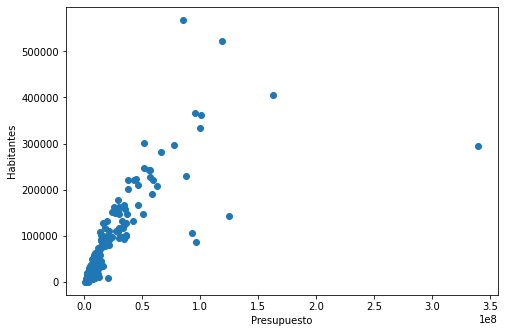

,id_comuna,presupuesto,habitantes
id_comuna,1.000000,0.195501,0.200169
presupuesto,0.195501,1.000000,0.772068
habitantes,0.200169,0.772068,1.000000


In [3]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(hab_pres_frame["presupuesto"], hab_pres_frame["habitantes"])
ax.set_xlabel('Presupuesto')
ax.set_ylabel('Habitantes')
plt.show()

hab_pres_frame.corr()

El presupuesto tiene alta correlación con los habitantes (0.772068 según la matriz de correlaciones).

Claramente se puede apreciar un outlier en el gráfico, al centro y arriba del gráfico. A partir de los ejes, se puede ver que es la única columna con presupuesto mayor a 3\*10^8. Por lo tanto, se puede filtrar fácilmente en el mismo dataframe.

In [4]:
hab_pres_frame[hab_pres_frame["presupuesto"] > 300000000]

,id_comuna,nombre,presupuesto,habitantes
263,13114,LAS CONDES,339980450,294838


El outlier es.... **LAS CONDES**

\**finje sorpresa*\* 😲😲😲😲😲

## 2.2 Descartando ciertos outliers

Para hacer esta parte, se uso SQL directamente en el CLI de SQLite3. Se uso la siguiente query:
```SQL
CREATE VIEW ComunaLimpia AS
SELECT comuna.id, comuna.nombre FROM comuna
INNER JOIN poblacion
ON comuna.id = poblacion.cod
WHERE poblacion.habitantes > 5000
AND comuna.nombre <> "LAS CONDES";
```

Y para comprobar que efectivamente posee una cantidad correcta de filas:

```SQL
SELECT COUNT(*) FROM ComunaLimpia;
```

## 2.3 Correlación entre el presupuesto y votación del aprueben


### Parte 1 (todas las comunas)

#### Obtener información de base de datos

In [5]:
# Connect to database
conn = sqlite3.connect('municipios.db')
conn.text_factory = lambda x: str(x, "latin-1")

# Create cursor
c = conn.cursor()

# Obtain data
query = '''
SELECT id_comuna, municipio, plata, (100.0 * CAST(apruebo AS FLOAT)/(apruebo + rechazo + blancos + nulos)) AS porcentaje_apruebo FROM presupuesto
INNER JOIN resultados_plebiscito
ON presupuesto.id_comuna = resultados_plebiscito.cod_com
'''

result = c.execute(query)

pres_pleb_frame = pd.DataFrame(result)

conn.close()

pres_pleb_frame.columns = ["id_comuna", "nombre", "presupuesto", "porcentaje_apruebo"]
pres_pleb_frame

,id_comuna,nombre,presupuesto,porcentaje_apruebo
0,1101,IQUIQUE,59072234,76.010970
1,1107,ALTO HOSPICIO,13984404,81.798002
2,1401,POZO ALMONTE,7613962,77.018377
3,1402,CAMIÑA,1584008,57.115010
4,1403,COLCHANE,2500000,25.000000
...,...,...,...,...
333,16301,SAN CARLOS,10459701,67.674316
334,16302,COIHUECO,5001190,61.142620
335,16303,ÑIQUÉN,3386698,61.479435
336,16304,SAN FABIÁN,1798500,71.827278


#### Graficar correlación

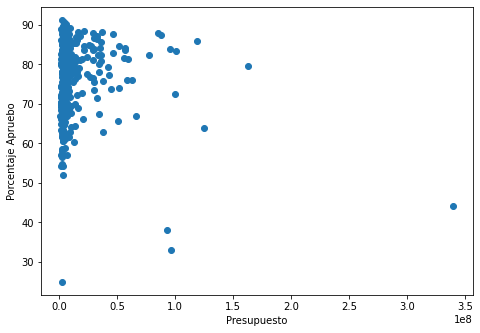

,id_comuna,presupuesto,porcentaje_apruebo
id_comuna,1.000000,0.129685,-0.229909
presupuesto,0.129685,1.000000,-0.070008
porcentaje_apruebo,-0.229909,-0.070008,1.000000


In [6]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(pres_pleb_frame["presupuesto"], pres_pleb_frame["porcentaje_apruebo"])
ax.set_xlabel('Presupuesto')
ax.set_ylabel('Porcentaje Apruebo')
plt.show()

pres_pleb_frame.corr()

Se puede apreciar una correlación entre el presupuesto y el porcentaje de votos del apruebo de aproximadamente **-0.070008**

Se puede ver que la correlación es relativamente baja, y además, es negativa. Esto significa que para este set de comunas, el presupuesto no está muy relacionado con el porcentaje de votos del apruebo. El hecho de que sea negativo, indica que mientras mayor sea el presupuesto, menor será el porcentaje de apruebo, sin embargo, como se dijo anteriormente, la correlación es muy baja, por lo que no se puede aseverar lo anterior.

### Parte 2 (comunas limpias)

#### Obtener información de base de datos

In [7]:
# Connect to database
conn = sqlite3.connect('municipios.db')
conn.text_factory = lambda x: str(x, "latin-1")

# Create cursor
c = conn.cursor()

# Obtain data
query = '''
SELECT ComunaLimpia.id, ComunaLimpia.nombre, presupuesto.plata, (100.0 * CAST(apruebo AS FLOAT)/(apruebo + rechazo + blancos + nulos)) AS porcentaje_apruebo FROM ComunaLimpia
INNER JOIN presupuesto
ON ComunaLimpia.id = presupuesto.id_comuna
INNER JOIN resultados_plebiscito
ON ComunaLimpia.id = resultados_plebiscito.cod_com
'''

result = c.execute(query)

pres_pleb_limpia_frame = pd.DataFrame(result)

conn.close()

pres_pleb_limpia_frame.columns = ["id_comuna", "nombre", "presupuesto", "porcentaje_apruebo"]
pres_pleb_limpia_frame

,id_comuna,nombre,presupuesto,porcentaje_apruebo
0,1101,IQUIQUE,59072234,76.010970
1,1107,ALTO HOSPICIO,13984404,81.798002
2,1401,POZO ALMONTE,7613962,77.018377
3,1405,PICA,5887820,72.648871
4,2101,ANTOFAGASTA,100635302,83.278616
...,...,...,...,...
276,14201,LA UNIÓN,6839300,72.100356
277,14202,FUTRONO,3486415,60.644258
278,14203,LAGO RANCO,3135370,62.514934
279,14204,RÍO BUENO,5771272,68.140833


#### Graficar correlación

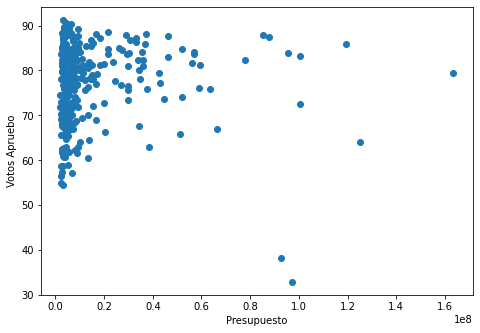

,id_comuna,presupuesto,porcentaje_apruebo
id_comuna,1.000000,0.229504,-0.212196
presupuesto,0.229504,1.000000,0.013928
porcentaje_apruebo,-0.212196,0.013928,1.000000


In [8]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(pres_pleb_limpia_frame["presupuesto"], pres_pleb_limpia_frame["porcentaje_apruebo"])
ax.set_xlabel('Presupuesto')
ax.set_ylabel('Votos Apruebo')
plt.show()

pres_pleb_limpia_frame.corr()

Ahora, se puede apreciar una correlación entre el presupuesto y los votos de apruebo positiva, de aproximadamente **0.013928**.

### Parte 3

Como se mencionó anteriormente, la correlación ahora es positiva, pero al mismo tiempo, el valor absoluto de la correlación disminuyó (se acercó a 0).


Una de las razones de este cambio es que se sacó a la comuna outlier (es decir, Las Condes), la cual tenía un alto presupuesto, y relativamente bajo porcentaje de apruebo. Esta comuna causaba que se tendiera a mostrar una relación inversa entre la cantidad de votos de apruebo y el presupuesto, representado por una correlación negativa en el apartado anterior. Al sacarla, se quita este "peso", y cambia la correlación para el lado positivo. Aún así, el valor absoluto de la correlación es muy cercano a 0, por lo que es probable que las variables no tengan relación (según los datos).

Ánimo con las correcciones! 🤠🤠🤠